This notebook adresseses an employee scheduling problem involving multiple employees and tasks.

The objective studied is maximizing total number of tasks completed within available times of employees.

Each task can be assigned to at most one employee and preemption is not allowed. The duration of tasks is fixed (independent of the assigned employee) and it is assumed that each task can be assigned to any eligible employee (employees are capable to process tasks based on their skillset). Finally, employees are associated with availability start and end times.

In this notebook, it is aimed to highlight **sequence dependent setup times** based on task or job **categories**. A setup time occurs when employee switches from task of one department to a task of another department.

The scheduling problem can be also viewed as machine scheduling problem in which employees correspond to machines.

In [1]:
import pandas as pd
import math
import numpy as np
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

# READ DATA

In [2]:
employeesTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Employees', header=0)
employeesTable = employeesTable.head(5) # select only 5 employees in order to have a small-sized problem
employeesTable['Index'] = range(1, len(employeesTable) + 1)  
employeesTable

,name,availability_start,availability_end,seniority,qualification,pay_rate,Index
0,Anne,480,1020,11,1,25,1
1,Bethanie,480,1020,4,5,28,2
2,Betsy,480,1020,2,2,17,3
3,Cathy,480,1020,2,2,17,4
4,Cecilia,480,1020,9,5,38,5


In [3]:
departmentsTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Departments', header=0)
departmentsTable

,department_id,department
0,D01,Anaesthesiology
1,D02,Oncology
2,D03,Pediatrics
3,D04,Cardiac Care
4,D05,Geriatrics


In [4]:
tasksTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Tasks', header=0)
tasksTable = tasksTable.head(30) # select only 30 tasks in order to have a small-sized problem
tasksTable

,task_id,task_type,task_duration,required_nbr_of_employees
0,T001,Oncology,110,1
1,T002,Cardiac Care,80,1
2,T003,Anaesthesiology,60,1
3,T004,Pediatrics,70,1
4,T005,Oncology,120,1
5,T006,Cardiac Care,80,1
6,T007,Pediatrics,80,1
7,T008,Oncology,60,1
8,T009,Anaesthesiology,110,1
9,T010,Cardiac Care,30,1


In [5]:
skillsTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='Skills', header=0)
skillsTable

,name,department,Eligible?
0,Anne,Anaesthesiology,No
1,Bethanie,Anaesthesiology,Yes
2,Betsy,Anaesthesiology,Yes
3,Cathy,Anaesthesiology,Yes
4,Cecilia,Anaesthesiology,Yes
...,...,...,...
155,Roberta,Geriatrics,No
156,Suzanne,Geriatrics,Yes
157,Vickie,Geriatrics,No
158,Wendie,Geriatrics,Yes


In [6]:
setUpTimesTable = pd.read_excel("C:\\Users\\167295724\\Desktop\\EmployeeScheduling\\MasterData.xlsx", sheet_name='SetupTimes', header=0)
setUpTimesTable

,department_id,department,department_id.1,department.1,setuptime
0,D01,Anaesthesiology,D01,Anaesthesiology,0
1,D01,Anaesthesiology,D02,Oncology,15
2,D01,Anaesthesiology,D03,Pediatrics,15
3,D01,Anaesthesiology,D04,Cardiac Care,15
4,D01,Anaesthesiology,D05,Geriatrics,15
5,D02,Oncology,D01,Anaesthesiology,30
6,D02,Oncology,D02,Oncology,0
7,D02,Oncology,D03,Pediatrics,30
8,D02,Oncology,D04,Cardiac Care,30
9,D02,Oncology,D05,Geriatrics,30


In [7]:
# Create a new dataframe to show compatible employee-task pairs through the Skills Table

# Add a constant column to both DataFrames to perform the cross join
employeesTable['key'] = 1
tasksTable['key'] = 1

# Perform a cross join by merging on the constant column 'key' to list "all" employee-task pairs
cross_joined_df = pd.merge(employeesTable, tasksTable, on='key').drop('key', axis=1)[['name', 'availability_start','availability_end','task_id', 'task_type','task_duration','required_nbr_of_employees']]
employeesTable.drop('key', axis=1, inplace=True)
tasksTable.drop('key', axis=1, inplace=True)
cross_joined_df = cross_joined_df.rename(columns={'task_type': 'department'})
#cross_joined_df

# Create new a table which lists only the tasks that can be processed by corresponding employee among "all" employee-task pairs
employeeTasksTable = pd.merge(cross_joined_df, skillsTable, on=['name', 'department'], how='inner')
employeeTasksTable = employeeTasksTable.sort_values(by=['name', 'task_id'], ascending=[True, True])
employeeTasksTable = employeeTasksTable[employeeTasksTable['Eligible?'] == "Yes"]
employeeTasksTable['RowIndex'] = range(0, len(employeeTasksTable)) # index is generated to be used in setup matrix
employeeTasksTable  

,name,availability_start,availability_end,task_id,department,task_duration,required_nbr_of_employees,Eligible?,RowIndex
0,Anne,480,1020,T001,Oncology,110,1,Yes,0
9,Anne,480,1020,T002,Cardiac Care,80,1,Yes,1
1,Anne,480,1020,T005,Oncology,120,1,Yes,2
10,Anne,480,1020,T006,Cardiac Care,80,1,Yes,3
2,Anne,480,1020,T008,Oncology,60,1,Yes,4
...,...,...,...,...,...,...,...,...,...
126,Cecilia,480,1020,T026,Oncology,60,2,Yes,76
139,Cecilia,480,1020,T027,Anaesthesiology,110,1,Yes,77
140,Cecilia,480,1020,T028,Anaesthesiology,110,1,Yes,78
127,Cecilia,480,1020,T029,Oncology,120,1,Yes,79


# PREPARE DATA

Tuple data type can be used to retrieve certain values of each row of a dataframe (to be used in the optimization model). Each tuple set can correspond to an input table and the pandas method itertuples() returns a named tuple for each row of a DataFrame.

In [8]:
employeesT  = namedtuple("employeesT",['name', 'availabilityStart', 'availabilityEnd', 'seniority', 'qualification', 'payRate', 'index'])
employees  = [employeesT(*employees_row) for employees_row in employeesTable.itertuples(index=False)]
#employees 

In [9]:
departmentsT  = namedtuple("departmentsT",['departmentId','department'])
departments  = [departmentsT(*departments_row) for departments_row in departmentsTable.itertuples(index=False)]
#departments 

In [10]:
tasksT  = namedtuple("tasksT",['taskId', 'taskType', 'taskDuration','required_nbr_of_employees'])
tasks  = [tasksT(*tasks_row) for tasks_row in tasksTable.itertuples(index=False)]
#tasks 

In [11]:
employeeTasksT  = namedtuple("employeeTasksT",['name', 'availabilityStart', 'availabilityEnd', 'taskId', 'department', 'taskDuration','requiredNbrOfEmployees','eligible','row_index'])
employeeTasks  = [employeeTasksT(*employeeTasks_row) for employeeTasks_row in employeeTasksTable.itertuples(index=False)]
#employeeTasks

In [12]:
setUpTimesT  = namedtuple("tasksT",['fromDepartmentId', 'fromDepartment', 'toDepartmentId', 'toDepartment','setupTime'])
setUpTimes  = [setUpTimesT(*setUpTimes_row) for setUpTimes_row in setUpTimesTable.itertuples(index=False)]
#setUpTimes 

In [13]:
setup_matrix=[[0 for et in employeeTasks]for et in employeeTasks]
for et_from in employeeTasks:
    for et_to in employeeTasks:
        for st in setUpTimes:
            if et_from.department == st.fromDepartment and et_to.department == st.toDepartment:
                #print (et_from.row_index)
                setup_matrix[et_from.row_index][et_to.row_index] = st.setupTime
setup_matrix

[[0,
  30,
  0,
  30,
  0,
  30,
  0,
  0,
  0,
  30,
  0,
  0,
  0,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  0,
  30,
  0,
  0,
  30,
  30,
  0,
  0,
  30,
  30,
  30,
  30,
  30,
  30,
  0,
  30,
  30,
  0,
  30,
  30,
  0,
  0,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  0,
  30,
  30,
  0,
  30,
  0,
  30,
  30,
  0,
  0,
  30,
  30,
  30,
  30,
  30,
  30,
  30,
  0,
  30,
  30,
  30,
  0,
  30,
  30,
  0,
  0],
 [60,
  0,
  60,
  0,
  60,
  0,
  60,
  60,
  60,
  0,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  0,
  60,
  0,
  60,
  0,
  60,
  60,
  60,
  60,
  0,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60,
  60],
 [0,
  30,
  0,
  30,
  0,
  30,
  0,
  0,
  0,
  30,
  0,
  

# CREATE A MODEL INSTANCE

In [14]:
from docplex.cp.model import *
mdl = CpoModel(name='employeeScheduling') 

# DEFINE DECISION VARIABLES

In [15]:
# define  processing interval of each task at each "eligible" employee
employeeTasks_itv_vars = {}   
for et in employeeTasks:
    employeeTasks_itv_vars[et] = mdl.interval_var(start=(et.availabilityStart,et.availabilityEnd), end=(et.availabilityStart,et.availabilityEnd), size=et.taskDuration, optional=True)

In [16]:
# define sequencing variables for each employee (to be used in no overlap constraint)
sequence_vars = {}  
for e in employees:
    sequence_vars [e] = mdl.sequence_var([employeeTasks_itv_vars[et] for et in employeeTasks if et.name==e.name], types = [et.row_index for et in employeeTasks if et.name==e.name])

# EXPRESS OBJECTIVE FUNCTION

In [17]:
# maximize number of tasks that are completed by an employee
objective = mdl.sum([mdl.presence_of(employeeTasks_itv_vars[et]) for et in employeeTasks])
mdl.add(mdl.maximize(objective)) 

# DEFINE CONSTRAINTS

In [18]:
# each task can be assigned to at most one employee
for t in tasks:
    mdl.add(mdl.sum(mdl.presence_of(employeeTasks_itv_vars[et]) for et in employeeTasks if et.taskId==t.taskId)<=1)

In [19]:
# no overlap constraint
for e in employees:
    mdl.add(mdl.no_overlap(sequence_vars[e],setup_matrix)) 

# SOLVE THE MODEL

In [20]:
msol=mdl.solve(TimeLimit=60, execfile='C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio221\\cpoptimizer\\bin\\x64_win64\\cpoptimizer.exe')
print("Solution: ")
msol.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Maximization problem - 86 variables, 35 constraints
 ! Presolve      : 9 extractables eliminated
 ! TimeLimit            = 60
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 515.0 (before), 515.0 (after)
 !  . Memory usage      : 712.9 kB (before), 712.9 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         86                 -
 + New bound is 81
 ! Using iterative diving.
 ! Using temporal relaxation.
                        0         86    1            -
 + New bound is 30
 *            23       97  0.12s        1      (gap is 30.43%)
 *            24      231  0.12s        1      (gap is 25.00%)
 *            26      429  0.12s        1      (gap is 15.38%)
 *            28      5

# PREPARE OUTPUT TABLES

In [21]:
assignmentReport = [(et.name, et.taskId, et.department
                    ,msol.get_var_solution(employeeTasks_itv_vars[et]).get_start(),msol.get_var_solution(employeeTasks_itv_vars[et]).get_end()) 
                       for et in employeeTasks if msol.get_var_solution(employeeTasks_itv_vars[et]).is_present()]
assignmentReport_df = pd.DataFrame(assignmentReport, columns=['Employee', 'Task', 'Type','StartTime','EndTime'])
assignmentReport_df = assignmentReport_df.sort_values(by=['Employee', 'StartTime'], ascending=[True, True])
assignmentReport_df.head(50)

,Employee,Task,Type,StartTime,EndTime
4,Anne,T013,Oncology,480,590
0,Anne,T001,Oncology,590,700
5,Anne,T021,Oncology,700,780
2,Anne,T008,Oncology,780,840
1,Anne,T005,Oncology,840,960
3,Anne,T010,Cardiac Care,990,1020
8,Bethanie,T019,Anaesthesiology,480,600
6,Bethanie,T009,Anaesthesiology,600,710
10,Bethanie,T028,Anaesthesiology,710,820
7,Bethanie,T018,Anaesthesiology,820,910


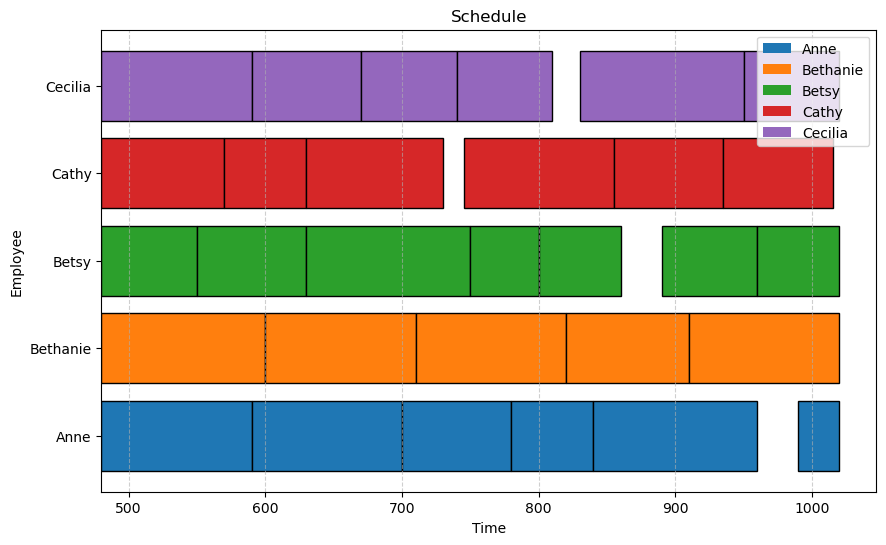

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Your data
df = assignmentReport_df

# Automatically define colors for resources using a colormap
cmap = plt.cm.get_cmap('tab10')  # You can choose other colormaps
colors = [cmap(i) for i in range(len(df['Employee'].unique()))]
resource_colors = dict(zip(df['Employee'].unique(), colors))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Gantt chart
for i, row in df.iterrows():
    start_time = row['StartTime']
    end_time = row['EndTime']
    task_duration = end_time - start_time
    ax.barh(row['Employee'], task_duration, left=start_time, color=resource_colors[row['Employee']], edgecolor='black', label="EEEE")

# Customize the chart
ax.set_xlabel('Time')
ax.set_ylabel('Employee')
ax.set_title('Schedule')

# Customize legend
legend_labels = [plt.Rectangle((0,0),1,1,fc=resource_colors[resource]) for resource in df['Employee'].unique()]
ax.legend(legend_labels, df['Employee'].unique())

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()